# GeekBrains / Курсовой проект по курсу "Python для Data Science"
## _Предсказание цен на недвижимость в г.Москва_
### Студент: А.Николаев
#### 03.07.2019

In [1]:
import datetime
import numpy as np
import pandas as pd
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [3]:
GRS = 42

In [4]:
data_raw = pd.read_csv('train.csv', index_col=0, encoding='utf-8')
data_raw.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.5+ MB


###### Видим, что признак 'Helthcare_2' назван неверно. Переименуем, чтобы самим не делать потом ошибок.

In [6]:
data_raw = data_raw.rename(columns={'Helthcare_2':'Healthcare_2'})

In [7]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Healthcare_2     10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.5+ MB


In [8]:
pp.ProfileReport(data_raw)

### ОБРАБОТКА ДАННЫХ

In [9]:
mean_price_all = data_raw['Price'].mean()
mean_price = data_raw.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price']].mean().\
                        rename(columns={'Price':'mean_price'})
mean_price2 = data_raw.groupby('Rooms', as_index=False)[['Price']].mean().\
                        rename(columns={'Price':'mean_price2'})

**Rooms**
> В поле Rooms наблюдаются данные выбросы: 
- 0 комнат
- 1,2,3,4,5,6 комнат
- 10 комнат
- 19 комнат

In [10]:
data_raw.Rooms.describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [11]:
def fix_rooms(df):
    df.loc[(df['Rooms'] < 1) | (df['Rooms'] >= 10), 'Rooms'] = 1
    df.loc[df['Rooms'] == 6, 'Rooms'] = 5
    df['Rooms'] = df['Rooms'].astype('int')
    return df

**Square**
> В поле Square наблюдаются данные выбросы: 
- min = 1.13 м.кв
- max = 641.06 м.кв

In [12]:
data_raw.Square.describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [13]:
def fix_square(df):
    mean_square = df['Square'].mean()
    df.loc[df['Square'] < 10.0, 'Square'] = df['Square'] * 10
    df.loc[df['Square'] > 300.0, 'Square'] = df['Square'] / 10
    df['Square'] = df['Square'].fillna(mean_square)
    return df

**LifeSquare**
> В поле LifeSquare наблюдаются данные выбросы: 
- min = 0.37 м.кв
- max = 7480.59 м.кв
- count = 7888 - есть пропуски данных

In [14]:
data_raw.LifeSquare.describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [15]:
def fix_lifesquare(df):
    mean_square_per_rooms = df.groupby(['Rooms'], as_index=False)[['Square']].mean().\
            rename(columns={'Square':'mean_square'})
    mean_lifesquare_per_rooms = df.groupby(['Rooms'], as_index=False)[['LifeSquare']].mean().\
            rename(columns={'LifeSquare':'mean_lifesquare'})
    ratio = pd.DataFrame(mean_lifesquare_per_rooms['mean_lifesquare'] \
                         / mean_square_per_rooms['mean_square']).rename(columns = {0:'Ratio'})
    ratio['Rooms'] = mean_square_per_rooms['Rooms']
    df = pd.merge(df, ratio, on='Rooms', how='left')
    df['LifeSquare'] = df['LifeSquare'].fillna(df['Ratio'] * df['Square'])
    df.loc[(df['LifeSquare'] < 10), 'LifeSquare'] = df['Ratio'] * df['Square']
    df.loc[(df['LifeSquare'] > df['Square']), 'LifeSquare'] = df['Ratio'] * df['Square']
    df = df.drop('Ratio', axis=1)
    return df

**HouseYear**
> В признаке HouseYear наблюдаются данные выбросы: 
- 2020 год
- 4968 год
- 20052011 год

In [16]:
data_raw.HouseYear.describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [17]:
def fix_houseyear(df):
    current_year = datetime.date.today().year
    df.loc[df['HouseYear'] == 2020, 'HouseYear'] = current_year
    mean_year = np.round(df.loc[df['HouseYear'] <= current_year, 'HouseYear'].mean())
    df['HouseYear'] = df['HouseYear'].fillna(mean_year)
    mean_century, mean_decade = map(int, divmod(mean_year, 100))
    anomaly_year = df.loc[(df['HouseYear'] > 2019) | (df['HouseYear'] <= 100) | \
                          (df['HouseYear'] <= 0), 'HouseYear']
    for year in anomaly_year:
        ly = len(str(year))
        if ly > 4 or ly == 1 or ly == 3 or year <= 0:
            df.loc[(df['HouseYear'] == year), 'HouseYear'] = mean_year
        elif ly == 2:
            df.loc[(df['HouseYear'] == year), 'HouseYear'] = int(str(mean_century) + str(year))
        else:
            century, decade = map(int, divmod(year, 100))
            df.loc[(df['HouseYear'] == year), 'HouseYear'] = int(str(mean_century) + str(decade))
    df['HouseYear'] = df['HouseYear'].astype('int')
    return df

**HouseFloor**
> В признаке HouseFloor наблюдаются данные выбросы: 
- 0 этажей
- 99 этаж
- 117 этаж

По данным Wikipedia, самое высокое жилое здание в МСК - [Список самых высоких зданий Москвы](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%B2%D1%8B%D1%81%D0%BE%D0%BA%D0%B8%D1%85_%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B9_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B).

Будем считать HouseFloor_max = 95

In [18]:
data_raw.HouseFloor.describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [19]:
def fix_housefloor(df):
    housefloor_max = 95
    mean_housefloor_per_year = np.round(df.groupby(['HouseYear'], as_index=False)[['HouseFloor']].mean().\
            rename(columns={'HouseFloor':'mean_floor'}))
    df = pd.merge(df, mean_housefloor_per_year, on='HouseYear', how='left')
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['mean_floor']
    df.loc[df['HouseFloor'] > housefloor_max, 'HouseFloor'] = df['mean_floor']
    mean_housefloor = np.round(df['mean_floor'].mean())
    df['HouseFloor'] = df['HouseFloor'].fillna(mean_housefloor)
    df['HouseFloor'] = df['HouseFloor'].astype('int')
    df = df.drop('mean_floor', axis=1)
    return df

**Floor**
> В признаке Floor наблюдаются данные выбросы: 
- этаж квартиры может быть больше, чем этаж дома

In [20]:
data_raw.Floor.describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [21]:
def fix_floor(df):
    df.loc[(df['Floor'] > df['HouseFloor']) & (df['HouseFloor'] == 1),\
           'HouseFloor'] = df['Floor']
    df[['Floor','HouseFloor']] = df[['HouseFloor','Floor']].where(\
        df['Floor'] > df['HouseFloor'], df[['Floor','HouseFloor']].values)
    return df

**KitchenSquare**
> В поле KichenSquare наблюдаются данные выбросы: 
- min = 0.37 м.кв
- max = 7480.59 м.кв
- count = 7888 - есть пропуски данных

In [22]:
data_raw.KitchenSquare.describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [23]:
def fix_kitchensquare(df):
    df['kitchen_area'] = (df['Square'] - df['LifeSquare']) * 0.55
    df.loc[df['KitchenSquare'] > (df['Square'] - df['LifeSquare']), \
           'KitchenSquare'] = df['kitchen_area']
    mean_kitchen_area = df.groupby(['Rooms', 'HouseYear'],\
                                as_index=False)[['kitchen_area']].mean().\
                                rename(columns={'kitchen_area':'mean_kitchen_area'})
    df = pd.merge(df, mean_kitchen_area, on=['Rooms', 'HouseYear'], how='left')
    mean_kitchensquare = df['mean_kitchen_area'].mean()
    df.loc[(df['KitchenSquare'] == 0.0) | (df['KitchenSquare'] <= 5.0),\
           'KitchenSquare'] = df['mean_kitchen_area']
    df['KitchenSquare'] = df['KitchenSquare'].fillna(mean_kitchensquare)
    df = df.drop('kitchen_area', axis=1)
    df = df.drop('mean_kitchen_area', axis=1)
    return df

**Healthcare**
> В признаке Healthcare_1 наблюдаются данные выбросы: 
- count = 5202 - есть пропуски данных

In [24]:
data_raw.Healthcare_1.describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [25]:
def fix_healthcare(df):
    mean_healthcare_1 = df.groupby(['DistrictId', 'Healthcare_2'],\
                                    as_index=False)[['Healthcare_1']].mean().\
                                    rename(columns={'Healthcare_1':'mean_healthcare_1'})
    mean_healthcare_2 = df.groupby(['Healthcare_2'], as_index=False)[['Healthcare_1']].\
                                    mean().rename(columns={'Healthcare_1':'mean_healthcare_2'})
    df = pd.merge(df, mean_healthcare_1, on=['DistrictId', 'Healthcare_2'], how='left')
    df = pd.merge(df, mean_healthcare_2, on=['Healthcare_2'], how='left')
    df['mean_healthcare_1'] = df['mean_healthcare_1'].fillna(df['mean_healthcare_2'])
    df['Healthcare_1'] = df['Healthcare_1'].fillna(df['mean_healthcare_1'])
    df = df.drop('mean_healthcare_1', axis=1)
    df = df.drop('mean_healthcare_2', axis=1)
    return df

In [26]:
def prep_bigdistrict_feature(df):
    districts = df['DistrictId'].value_counts().reset_index().\
                    rename(columns={'index':'DistrictId', 'DistrictId':'HousesQuantity'})
    districts['BigDistrict'] = (districts['HousesQuantity'] > 100).astype(int)
    df = pd.merge(df, districts, on='DistrictId', how='left')
    df = df.drop('HousesQuantity', axis=1)
    return df

In [27]:
def add_mean_price(df, mean_price=mean_price, mean_price2=mean_price2):
    global mean_price_all
    df = pd.merge(df, mean_price2, on='Rooms', how='left')
    df['mean_price2'] = df['mean_price2'].fillna(mean_price_all)
    df = pd.merge(df, mean_price, on=['DistrictId', 'Rooms'], how='left')
    df['mean_price'] = df['mean_price'].fillna(df['mean_price2'])
    df = df.drop('mean_price2', axis=1)
    return df

In [28]:
def categorical2binary(df):
    for column in df.columns:
        df[column] = (df[column] == 'A').astype(int)
    return df

In [29]:
def prepare_data(df):
    df = fix_rooms(df)
    df = fix_square(df)
    df = fix_lifesquare(df)
    df = fix_houseyear(df)
    df = fix_housefloor(df)
    df = fix_floor(df)
    df = fix_kitchensquare(df)
    df = prep_bigdistrict_feature(df)
    df = fix_healthcare(df)
    df = add_mean_price(df)
    return df

In [30]:
data_raw = prepare_data(data_raw)

In [31]:
data_raw.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,BigDistrict,mean_price
0,35,2,47.981561,29.442751,6.000000,7,9,1969,0.089040,B,B,33,7976,5,1007.781176,0,11,B,184966.930730,0,213160.076297
1,41,3,65.683640,40.049543,8.000000,7,9,1978,0.000070,B,B,46,10309,1,240.000000,1,16,B,300009.450063,0,303643.563728
2,53,2,44.947953,29.197612,8.831673,8,12,1968,0.049637,B,B,34,7759,0,229.000000,1,3,B,220925.908524,1,259938.729121
3,58,2,53.352981,52.731512,11.607633,8,17,1977,0.437885,B,B,23,5735,3,1084.000000,0,5,B,175616.227217,1,172368.882269
4,99,1,39.649192,23.776169,7.000000,11,12,1976,0.012339,B,B,35,5776,1,2078.000000,2,4,B,150226.531644,0,155748.415754


In [32]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 21 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null int32
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null int64
HouseYear        10000 non-null int32
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Healthcare_2     10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
BigDistrict      10000 non-null int32
mean_price       10000 non-null float64
dtypes: float64(7), int32(3), int64(8), object(3)
memory usage: 1.6+ MB


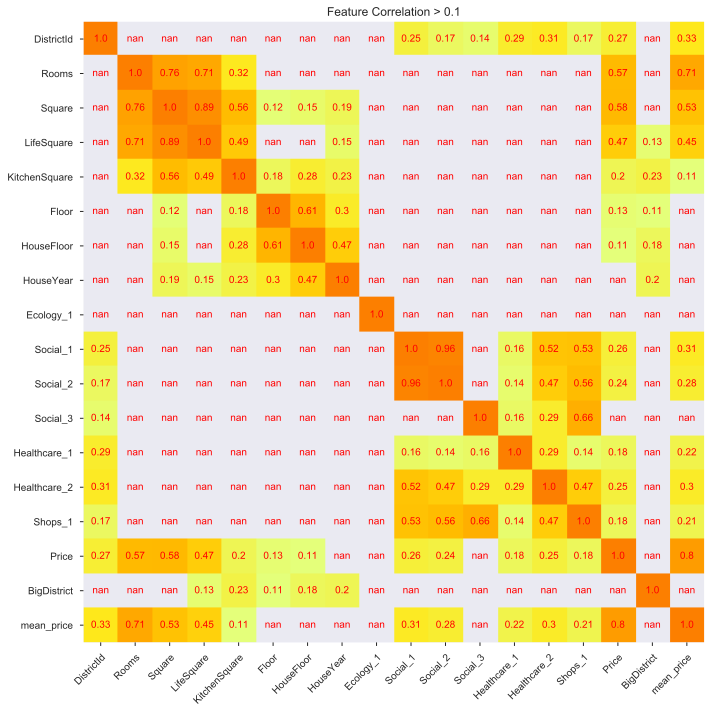

ВНИМАНИЕ!!!
Сильно коррелированными между собой признаками являются:
Social_1 Social_2


In [33]:
# ###
# Создаем температурную карту (heatmap) по перекрестной корреляции показателей
# для определения наиболее взаимозависимых из них
# ###
correlation_rate_minfilter = 0.1
correlation_rate_maxfilter = 0.9
correlation = data_raw.corr()
highly_correlated = correlation[(correlation >= correlation_rate_maxfilter) & (correlation != 1)]
highly_correlated = highly_correlated.loc[:, highly_correlated.notna().any()].columns.tolist()
rcParams['figure.figsize'] = 10, 10
heatmap_index = correlation.index
heatmap_colums = correlation.columns
heatmap_data = np.array(correlation.where(correlation > abs(correlation_rate_minfilter))).round(2)
fig, ax = plt.subplots()
im = ax.imshow(heatmap_data, cmap='Wistia')
ax.set_xticks(np.arange(len(heatmap_colums)))
ax.set_yticks(np.arange(len(heatmap_index)))
ax.set_xticklabels(heatmap_colums)
ax.set_yticklabels(heatmap_index)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
         rotation_mode='anchor')
for i in range(len(heatmap_index)):
    for j in range(len(heatmap_colums)):
        text = ax.text(j, i, heatmap_data[i, j],
                       ha='center', va='center', color='r', fontsize=10)
ax.set_title(f'Feature Correlation > {correlation_rate_minfilter}')
fig.tight_layout()
plt.grid()
plt.show()
print('ВНИМАНИЕ!!!')
print('Сильно коррелированными между собой признаками являются:')
print(*highly_correlated)

In [34]:
# ###
# Принимаем решение об удалении одного из сильно коррелированных межуд собой признаков
# ###
data_raw = data_raw.drop('Social_2', axis=1)

In [35]:
# ###
# Разобъем данные на категориальные и числовые признаки
# ###
categorical_columns = [c for c in data_raw.columns if data_raw[c].dtype.name == 'object']
numerical_columns = [c for c in data_raw.columns if data_raw[c].dtype.name != 'object']
data_categorical = data_raw[categorical_columns]
data_numerical = data_raw[numerical_columns]

In [36]:
# ###
# Преобразуем категориальные признаки в бинарные
# ###
data_categorical = categorical2binary(data_categorical)
data_categorical.head()

,Ecology_2,Ecology_3,Shops_2
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [37]:
# ###
# Нормализуем числовые признаки и наблюдения.
# Каждый числовой признак приведем к нулевому среднему и единичному среднеквадратичному отклонению.
# Хотя для ML алгоритма RandomForestRegressor это и не требуется.
# ###
data_numetical_columns = data_numerical.columns.tolist()
data_numetical_columns.remove('Price')
data_numetical_columns.remove('mean_price')
data_numetical_columns.remove('BigDistrict')
# ###
# Нормализация на стандартное отклонение
# ###
scale_features_std = StandardScaler()
data_numerical[data_numetical_columns] = scale_features_std.\
                                        fit_transform(data_numerical[data_numetical_columns])
data_numerical.head() 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,BigDistrict,mean_price
0,-0.353348,0.138400,-0.431087,-0.444918,-1.422615,-0.260824,-0.785565,-0.861777,-0.250529,0.474169,-0.127533,-0.017651,-0.883480,1.408356,184966.930730,0,213160.076297
1,-0.215687,1.369720,0.496686,0.240512,-0.541531,-0.260824,-0.785565,-0.372804,-0.998053,1.215681,-0.295384,-0.958528,-0.213923,2.448700,300009.450063,0,303643.563728
2,0.059635,0.138400,-0.590079,-0.460760,-0.175144,-0.065538,-0.266629,-0.916107,-0.581588,0.531208,-0.337347,-0.972008,-0.213923,-0.256195,220925.908524,1,259938.729121
3,0.174352,0.138400,-0.149569,1.060043,1.047783,-0.065538,0.598264,-0.427134,2.680470,-0.096225,-0.211458,0.075752,-0.883480,0.159943,175616.227217,1,172368.882269
4,1.115034,-1.092919,-0.867789,-0.811103,-0.982073,0.520319,-0.266629,-0.481465,-0.894969,0.588247,-0.295384,1.293849,0.455633,-0.048126,150226.531644,0,155748.415754


In [38]:
# ###
# Объеденим бинарные/категориальные и числовые признаки
# На выходе получаем очищенные + нормализованные данные!!!
# ###
data = pd.concat((data_numerical, data_categorical), axis=1)
data = pd.DataFrame(data, dtype=float)
data.to_csv('ANikolaev_data_after_preparation.csv', index=None)
data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,BigDistrict,mean_price,Ecology_2,Ecology_3,Shops_2
0,-0.353348,0.138400,-0.431087,-0.444918,-1.422615,-0.260824,-0.785565,-0.861777,-0.250529,0.474169,-0.127533,-0.017651,-0.883480,1.408356,184966.930730,0.0,213160.076297,0.0,0.0,0.0
1,-0.215687,1.369720,0.496686,0.240512,-0.541531,-0.260824,-0.785565,-0.372804,-0.998053,1.215681,-0.295384,-0.958528,-0.213923,2.448700,300009.450063,0.0,303643.563728,0.0,0.0,0.0
2,0.059635,0.138400,-0.590079,-0.460760,-0.175144,-0.065538,-0.266629,-0.916107,-0.581588,0.531208,-0.337347,-0.972008,-0.213923,-0.256195,220925.908524,1.0,259938.729121,0.0,0.0,0.0
3,0.174352,0.138400,-0.149569,1.060043,1.047783,-0.065538,0.598264,-0.427134,2.680470,-0.096225,-0.211458,0.075752,-0.883480,0.159943,175616.227217,1.0,172368.882269,0.0,0.0,0.0
4,1.115034,-1.092919,-0.867789,-0.811103,-0.982073,0.520319,-0.266629,-0.481465,-0.894969,0.588247,-0.295384,1.293849,0.455633,-0.048126,150226.531644,0.0,155748.415754,0.0,0.0,0.0


### МОДЕЛИРОВАНИЕ

In [39]:
train, valid = train_test_split(data, test_size=0.3, random_state=GRS)
print(train.shape, valid.shape)
feats = data.columns.tolist()
feats.remove('Price')

(7000, 20) (3000, 20)


#### Отбор лучшх признаков (Feature Selection) с помощью алгоритма случайного леса

In [40]:
# ###
# Предварительное обучение для выбора наиболее значимых признаков
# ###
model = RFR(max_depth=25, n_estimators=700, max_features=7, n_jobs=-1, random_state=GRS)
model.fit(train.loc[:, feats], train['Price'])
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print('Наиболее значимые признаки по убыванию:')
for f, i in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feats[i], importances[i]))

Наиболее значимые признаки по убыванию:
 1. feature 'mean_price' (0.3719)
 2. feature 'Square' (0.1893)
 3. feature 'LifeSquare' (0.0743)
 4. feature 'Rooms' (0.0642)
 5. feature 'Social_1' (0.0520)
 6. feature 'HouseYear' (0.0331)
 7. feature 'Social_3' (0.0305)
 8. feature 'HouseFloor' (0.0259)
 9. feature 'Floor' (0.0236)
10. feature 'KitchenSquare' (0.0234)
11. feature 'DistrictId' (0.0224)
12. feature 'BigDistrict' (0.0218)
13. feature 'Healthcare_1' (0.0201)
14. feature 'Ecology_1' (0.0191)
15. feature 'Shops_1' (0.0147)
16. feature 'Healthcare_2' (0.0114)
17. feature 'Shops_2' (0.0010)
18. feature 'Ecology_3' (0.0008)
19. feature 'Ecology_2' (0.0003)


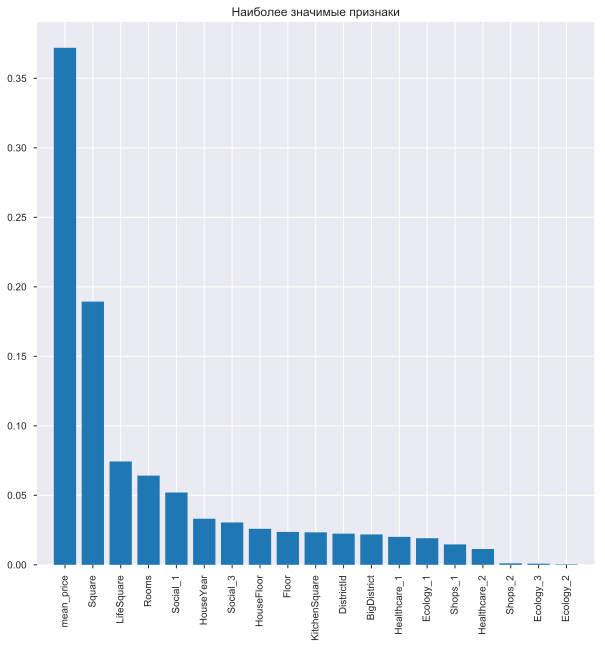

In [41]:
q_feats = len(feats)
plt.figure(figsize=(10, 10))
plt.title('Наиболее значимые признаки')
plt.bar(range(q_feats), importances[indices[:q_feats]], align='center')
plt.xticks(range(q_feats), np.array(feats)[indices[:q_feats]], rotation=90)
plt.xlim([-1, q_feats]);

#### !!! Из графика видно, что незначимыми признаками являются: Shops_2, Ecology_2, Ecology_3
Принимаем решение удалить эти признаки из обучения моделей

In [42]:
feats.remove('Shops_2')
feats.remove('Ecology_2')
feats.remove('Ecology_3')

### LR

In [43]:
model = LR()
model.fit(train.loc[:, feats], train['Price'])
y_pred_train = model.predict(train.loc[:, feats])
y_pred_train

array([106563.85754194, 289550.77158779, 182482.4679196 , ...,
       253429.18620833, 226018.59440394, 318264.28932693])

In [44]:
r2(train['Price'], y_pred_train)

0.7281490768211469

In [45]:
y_pred_valid = model.predict(valid.loc[:, feats])

In [46]:
r2(valid['Price'], y_pred_valid)

0.7026482888129741

### Random Forest Regressor

#### Для нахождения лучших параметров используем GridSearchCV с кросс-валидацией на 3 фолда

In [47]:
# estimator = RFR()
# param_grid = {
# 'max_depth' : [10, 15, 20, 25, 30],
# 'n_estimators' : [200, 300, 400, 500, 650, 700, 750],
# 'max_features' : [3, 4, 5, 7, 8, 9, 10],
# 'min_samples_leaf' : [1, 2, 3, 4, 5],
# 'min_samples_split' : [2, 4, 8],
# 'bootstrap': [True, False],
# 'random_state' : [GRS]
# }
# grid = GSCV(estimator, param_grid, n_jobs=-1, cv=3, verbose=1)
# grid.fit(train.loc[:, feats], train['Price'])
# print(grid.best_score_)
# print(grid.best_params_)

# ###
# Просчет ~512.6min на локальном компьютере
# Fitting 3 folds for each of 7350 candidates, totalling 22050 fits
# ###

### Лучшие параметры после прогона GridSearchCV
##### Best score - 0.7617614204743002
##### Best parametersw: 'bootstrap': True, 'max_depth': 25, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 700

In [48]:
params = {'max_depth': 25, 'max_features': 7, 'n_estimators': 700, \
          'criterion': 'mse', 'min_samples_leaf': 2, 'min_samples_split': 8, 'verbose': 1}
model = RFR(n_jobs=-1, random_state=GRS)
model.set_params(**params)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [49]:
model.fit(train.loc[:, feats], train['Price'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [50]:
y_pred_train = model.predict(train.loc[:, feats])
y_pred_train

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.1s finished


array([ 98769.01344085, 201730.30480667, 180459.44787665, ...,
       236878.6252973 , 196662.3289065 , 387208.23872126])

In [51]:
r2(train['Price'], y_pred_train)

0.9172425783796558

In [52]:
y_pred_valid = model.predict(valid.loc[:, feats])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.1s finished


In [53]:
r2(valid['Price'], y_pred_valid)

0.7545079797982297

### Работа с тестовой выборкой

In [54]:
test = pd.read_csv('test.csv')
test = test.rename(columns={'Helthcare_2':'Healthcare_2'})
test = prepare_data(test)
categorical_columns = [c for c in test.columns if test[c].dtype.name == 'object']
numerical_columns = [c for c in test.columns if test[c].dtype.name != 'object']
test_categorical = test[categorical_columns]
test_numerical = test[numerical_columns]
test_categorical = categorical2binary(test_categorical)
test_numetical_columns = test_numerical.columns.tolist()
test_numetical_columns.remove('Id')
test_numetical_columns.remove('mean_price')
test_numetical_columns.remove('BigDistrict')
test_numerical[test_numetical_columns] = scale_features_std.\
                                        fit_transform(test_numerical[test_numetical_columns])
test = pd.concat((test_numerical, test_categorical), axis=1)
test = test.drop('Social_2', axis=1)
test['Price'] = model.predict(test.loc[:, feats])
test.loc[:, ['Id', 'Price']].to_csv('ANikolaev_predictions.csv', index=None)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.1s finished


In [55]:
test['Price'].describe()

count      5000.000000
mean     214682.165739
std       77813.646877
min       68158.415893
25%      163600.953416
50%      195411.549082
75%      248643.624212
max      550721.935539
Name: Price, dtype: float64